In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import  layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping
import os
from wordcloud import WordCloud
%matplotlib inline

### Read Anime List Csv File

In [5]:
INPUT_DIR = r"E:\CODES\MLOps_Udemy\Section_3_Hybrid_Anime_Recommender_System\Content\artifacts\raw"
print(f"Looking for file in: {INPUT_DIR}")

Looking for file in: E:\CODES\MLOps_Udemy\Section_3_Hybrid_Anime_Recommender_System\Content\artifacts\raw


In [6]:
file_path = os.path.join(INPUT_DIR, "animelist.csv")
if not os.path.exists(file_path):
    print(f"Error: The file 'animelist.csv' does not exist in {INPUT_DIR}")
    print("Please make sure to place the animelist.csv file in the correct directory")
else:
    rating_df = pd.read_csv(file_path, usecols=['user_id', 'anime_id', 'rating'])

In [7]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [8]:
len(rating_df)

109224747

### Data Preprocessing

In [9]:
n_ratings = rating_df['user_id'].value_counts()

In [10]:
n_ratings

user_id
20807     17546
140590    17534
281232    17533
147331    17526
131988    17520
          ...  
259248        1
259247        1
345120        1
287410        1
307120        1
Name: count, Length: 325770, dtype: int64

In [11]:
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)]

In [12]:
len(rating_df)

71418114

In [13]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
print(f"Min rating: {min_rating}, Max rating: {max_rating}")

Min rating: 0, Max rating: 10


In [14]:
avg_rating = rating_df["rating"].mean()
print(f"Avg rating: {avg_rating}")

Avg rating: 4.047793589172629


In [15]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

In [16]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
print(f"Min rating: {min_rating}, Max rating: {max_rating}")

Min rating: 0.0, Max rating: 1.0


In [17]:
avg_rating = rating_df["rating"].mean()
print(f"Avg rating: {avg_rating}")

Avg rating: 0.4047793589172634


In [18]:
rating_df.duplicated().sum()

1

In [19]:
rating_df = rating_df.drop_duplicates()

In [20]:
rating_df.duplicated().sum()

0

In [21]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [36]:
user_ids = rating_df['user_id'].unique().tolist()
user2user_encoded = {x: i for i,x in enumerate(user_ids)}
user2user_decoded = {i: x for i,x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [34]:
user2user_encoded[398]

100

In [35]:
user2user_decoded[100]

398

In [37]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [38]:
n_users = len(user2user_encoded)
print(f"Number of users: {n_users}")

Number of users: 91641


In [39]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x: i for i,x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i,x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [41]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [40]:
n_animes = len(anime2anime_encoded)
print(f"Number of animes: {n_animes}")

Number of animes: 17560


In [42]:
rating_df.sample(frac = 1 ,random_state = 42).reset_index(drop = True)

,user_id,anime_id,rating,user,anime
0,77277,1894,0.4,19983,797
1,221403,777,0.9,57395,193
2,270652,36474,0.8,70189,2052
3,276964,1089,0.7,71853,2329
4,99838,31043,1.0,25806,1027
...,...,...,...,...,...
71418108,65708,21939,0.0,17011,1397
71418109,104757,71,0.4,27060,32
71418110,281232,938,0.0,72994,11024
71418111,280685,30279,0.7,72843,5080


In [43]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"].values
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (71418113, 2), y shape: (71418113,)


In [44]:
test_size = 5000
train_indices = rating_df.shape[0] - test_size

In [45]:
X_train,X_test , y_train,y_test = X[:train_indices],X[train_indices:],y[:train_indices],y[train_indices:]

In [47]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((71413113, 2), (5000, 2), (71413113,), (5000,))

In [48]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [49]:
X_train_array = [X_train[:,0],X_train[:,1]]
X_test_array = [X_test[:,0],X_test[:,1]]

In [50]:
type(X_train_array), type(X_test_array), type(y_train), type(y_test)

(list, list, numpy.ndarray, numpy.ndarray)

### Model Architecture

In [ ]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users,
                       output_dim = embedding_size)(user)

    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                       input_dim = n_animes,
                       output_dim = embedding_size)(anime)

    #x = Concatenate()([user_embedding, anime_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')

    return model


In [71]:
model = RecommenderNet()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     


 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 anime (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       11730048    ['user[0][0]']                   
                                                                                                  
 anime_embedding (Embedding)    (None, 1, 128)       2247680     ['anime[0][0]']                  
                                                                                                  
 dot_product (Dot)              (None, 1, 1)         0           ['user_embedding[0][0]',         
                                                                  'anime_embedding[0][0]']        
          

In [ ]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000


rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss',
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,
]

In [73]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)


Epoch 1/20
7142/7142 [==============================] - 81s 11ms/step - loss: 0.7930 - mae: 0.3829 - mse: 0.1963 - val_loss: 0.7755 - val_mae: 0.3882 - val_mse: 0.1976 - lr: 1.0000e-05
Epoch 2/20
7142/7142 [==============================] - 74s 10ms/step - loss: 0.7554 - mae: 0.3725 - mse: 0.1819 - val_loss: 0.7324 - val_mae: 0.3783 - val_mse: 0.1806 - lr: 1.8000e-05
Epoch 3/20
7142/7142 [==============================] - 70s 10ms/step - loss: 0.6363 - mae: 0.3153 - mse: 0.1304 - val_loss: 0.6575 - val_mae: 0.3631 - val_mse: 0.1475 - lr: 2.6000e-05
Epoch 4/20
7142/7142 [==============================] - 72s 10ms/step - loss: 0.5595 - mae: 0.2643 - mse: 0.0976 - val_loss: 0.6543 - val_mae: 0.3578 - val_mse: 0.1449 - lr: 3.4000e-05
Epoch 5/20
7142/7142 [==============================] - 71s 10ms/step - loss: 0.5270 - mae: 0.2349 - mse: 0.0854 - val_loss: 0.6654 - val_mae: 0.3542 - val_mse: 0.1481 - lr: 4.2000e-05
Epoch 6/20
7142/7142 [==============================] - 71s 10ms/step - los

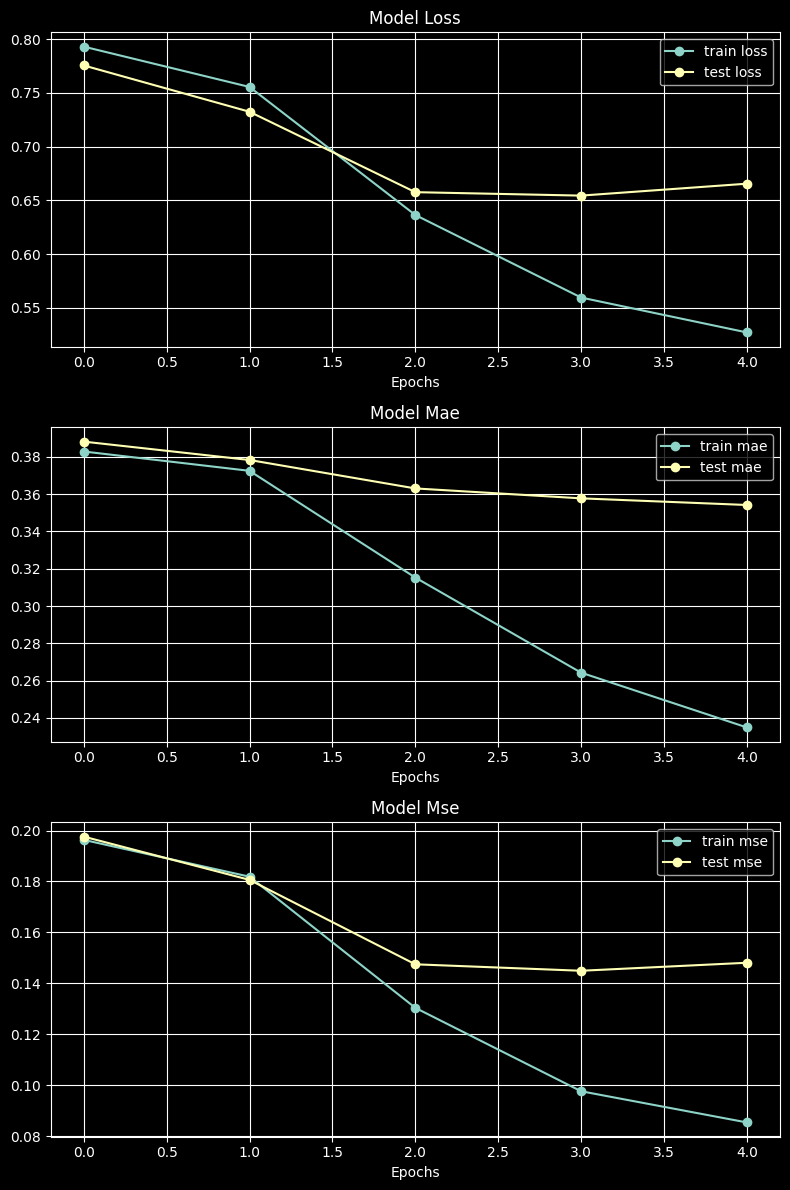

In [74]:
metrics = ["loss", "mae", "mse"]

fig,axes = plt.subplots(len(metrics),1,figsize=(8,len(metrics)*4))
for i,metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2],marker="o",label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2],marker="o",label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_xlabel("Epochs")
    ax.legend(loc="upper right")
    ax.grid(True)
plt.tight_layout()
plt.show()

In [75]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis=1).reshape(-1, 1)
    return weights

In [76]:
anime_weights = extract_weights("anime_embedding",model)
user_weights = extract_weights("user_embedding",model)
anime_weights.shape, user_weights.shape

((17560, 128), (91641, 128))

### Reading Anime CSV

In [80]:
pd.set_option('display.max_columns', None)

In [93]:
df = pd.read_csv(INPUT_DIR + r"\anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [94]:
df = df.replace("Unknown", np.nan)

In [95]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [ ]:
def get_anime_name(anime_id):
    try:
        mask = df['anime_id'] == anime_id
        eng_name = df[mask]['English name'].values[0]

        if pd.isna(eng_name):
            name = df[mask]['Name'].values[0]
        else:
            name = eng_name

        return name
    except (IndexError, KeyError):
        return f"Unknown Anime (ID: {anime_id})"

In [97]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df.anime_id.apply(lambda x : get_anime_name(x))

In [98]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop


In [105]:
get_anime_name(6)

'Trigun'

In [106]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [108]:
df.head(10)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",Bones,Manga,24 min. per ep.,R - 17+ (violence & profanity),1.0,3,2248456,183914,171871,1644938,75728,32456,323463,714811.0,401507.0,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,"Production I.G, Dentsu, Mainichi Broadcasting ...",Funimation,MAPPA,Manga,23 min. per ep.,R - 17+ (violence & profanity),2.0,119,733260,44862,566239,553,6658,2090,157720,173154.0,63756.0,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,"Frontier Works, Media Factory, Movic, AT-X, Ka...",Funimation,White Fox,Visual novel,24 min. per ep.,PG-13 - Teens 13 or older,3.0,9,1771162,148452,114349,1134756,60926,35600,425531,468504.0,275960.0,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,"Production I.G, Dentsu, Mainichi Broadcasting ...",Funimation,Wit Studio,Manga,23 min. per ep.,R - 17+ (violence & profanity),4.0,63,1073626,40985,54607,906824,5533,3099,103563,327290.0,239451.0,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,"TV Tokyo, Aniplex, Dentsu","Funimation, Crunchyroll",Bandai Namco Pictures,Manga,24 min. per ep.,PG-13 - Teens 13 or older,5.0,329,404121,11868,48011,167130,16612,11472,160896,78918.0,37902.0,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4
6474,11061,Hunter x Hunter (2011),9.1,"Action, Adventure, Fantasy, Shounen, Super Power",Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,TV,148,"Oct 2, 2011 to Sep 24, 2014",Fall 2011,"VAP, Nippon Television Network, Shueisha",VIZ Media,Madhouse,Manga,23 min. per ep.,PG-13 - Teens 13 or older,6.0,12,1673924,147274,227277,1094486,79587,31652,240922,454000.0,304741.0,167331.0,65085.0,18241.0,7789.0,2780.0,1243.0,1054.0,4602.0,11061,Hunter x Hunter
6006,9969,Gintama',9.08,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",Gintama Season 2,銀魂',TV,51,"Apr 4, 2011 to Mar 26, 2012",Spring 2011,"TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mira...",NaN,Sunrise,Manga,24 min. per ep.,PG-13 - Teens 13 or older,7.0,362,365579,6567,26492,190008,10615,7084,131380,74992.0,44740.0,24294.0,9584.0,3222.0,1655.0,694.0,338.0,437.0,2910.0,9969,Gintama Season 2
741,820,Ginga Eiyuu Densetsu,9.07,"Military, Sci-Fi, Space, Drama",Legend of the Galactic Heroes,銀河英雄伝説,OVA,110,"Jan 8, 1988 to Mar 17, 1997",NaN,"Kitty Films, K-Factory",Sentai Filmworks,"Artland, Magic Bus",Novel,26 min. per ep.,R - 17+ (violence & profanity),7.0,633,230168,13834,25968,52583,14911,5950,130756,30432.0,11497.0,7096.0,3577.0,1570.0,965.0,480.0,264.0,509.0,2265.0,820,Legend of the Galactic Heroes
7261,15417,Gintama': Enchousen,9.04,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama:Enchousen,銀魂' 延長戦,TV,1

In [109]:
df = df[["anime_id","eng_version","Score","Genres","Episodes","Type","Members","Premiered"]]

In [110]:
df.columns

Index(['anime_id', 'eng_version', 'Score', 'Genres', 'Episodes', 'Type',
       'Members', 'Premiered'],
      dtype='object')

In [111]:
def get_anime_frame(anime,df):
    if isinstance(anime, int):
        return df[df["anime_id"] == anime]
    elif isinstance(anime, str):
        return df[df["eng_version"] == anime]

In [112]:
get_anime_frame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Members,Premiered
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,733260,Winter 2021


In [113]:
get_anime_frame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Members,Premiered
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,1771162,Spring 2011


### ANIME WITH SYNOPSIS

In [116]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [117]:
synopsis_df = pd.read_csv(INPUT_DIR + r"\anime_with_synopsis.csv",low_memory=True,usecols=cols)

In [118]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [121]:
def get_synopsis(anime,df):
    if isinstance(anime, int):
        return df[df["MAL_ID"] == anime]["sypnopsis"].values[0]
    elif isinstance(anime, str):
        return df[df["Name"] == anime]["sypnopsis"].values[0]

In [125]:
get_synopsis(40028,synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [123]:
get_synopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### Contnet\Iten Based Recommendation System

In [126]:
pd.set_option('display.max_colwidth', None)

In [127]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronge

In [131]:
get_anime_frame(40028,df)['anime_id'].values[0]

40028

In [132]:
anime2anime_encoded[40028]

1666

In [133]:
np.dot(anime_weights, anime_weights[1666])

array([-0.01108047,  0.16441683, -0.10822806, ...,  0.01866789,
        0.01531918, -0.10212287], dtype=float32)

In [134]:
np.argsort(np.dot(anime_weights, anime_weights[1666]))

array([14176, 17537, 10470, ...,   230,  3453,  1666], dtype=int64)

In [ ]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    """
    Find similar animes based on the given anime name.
    Args:
        name (str): The name of the anime to find similar animes for.
        anime_weights (numpy.ndarray): The weights of the animes.
        anime2anime_encoded (dict): A dictionary mapping anime names to their encoded values.
        anime2anime_decoded (dict): A dictionary mapping encoded values back to anime names.
        df (pandas.DataFrame): The DataFrame containing anime information.
        synopsis_df (pandas.DataFrame): The DataFrame containing anime synopses.
        n (int, optional): The number of similar animes to return. Defaults to 10.
        return_dist (bool, optional): Whether to return distances. Defaults to False.
        neg (bool, optional): Whether to return negative distances. Defaults to False.
    Returns:
        pandas.DataFrame: DataFrame containing similar anime information
    """
    try:
        # Get anime ID from name
        anime_frame = get_anime_frame(name, df)
        if anime_frame.empty:
            print(f"Error: Anime '{name}' not found in database")
            return None

        index = anime_frame["anime_id"].values[0] # type: ignore
        encoded_index = anime2anime_encoded.get(index)
        if encoded_index is None:
            print(f"Error: Anime ID {index} not found in encoded mapping")
            return None

        # Calculate similarities
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n += 1
        closest = sorted_dists[:n] if neg else sorted_dists[-n:]

        print(f"Anime closest to '{name}':\n")

        if return_dist:
            return dists, closest

        # Build similarity array
        SimilarityArr = []
        for close in closest:
            try:
                decoded_id = anime2anime_decoded.get(close)
                if decoded_id is None:
                    continue

                synopsis = get_synopsis(decoded_id, synopsis_df)
                anime_frame = get_anime_frame(decoded_id, df)

                if anime_frame.empty:
                    continue

                anime_name = anime_frame["eng_version"].values[0] # type: ignore
                genre = anime_frame["Genres"].values[0] # type: ignore
                similarity = dists[close]

                SimilarityArr.append({
                    "anime_id": decoded_id,
                    "anime_name": anime_name,
                    "similarity": similarity,
                    "synopsis": synopsis,
                    "genre": genre
                })
            except Exception as e:
                print(f"Warning: Error processing anime {decoded_id}: {str(e)}")
                continue

        if not SimilarityArr:
            print("Error: No similar animes found")
            return None

        Frame = pd.DataFrame(SimilarityArr)
        Frame = Frame.sort_values(by=["similarity"], ascending=False)
        return Frame[Frame["anime_id"] != index].drop(["anime_id"], axis=1)

    except Exception as e:
        print(f"Error: {str(e)}")
        return None

In [152]:
find_similar_animes("Dragon Ball Z",anime_weights,
                    anime2anime_encoded,anime2anime_decoded,
                    df,synopsis_df,n=2,return_dist=False,neg=False)

Anime closest to 'Dragon Ball Z':



,anime_name,similarity,synopsis,genre
1,Code Geass:Lelouch of the Rebellion R2,0.959243,"One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series.","Action, Military, Sci-Fi, Super Power, Drama, Mecha"
0,Code Geass:Lelouch of the Rebellion,0.954825,"In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all.","Action, Military, Sci-Fi, Super Power, Drama, Mecha, School"
